# Lab 5: Spam Detection

In this assignment, we will build a recurrent neural network to classify a SMS text message
as "spam" or "not spam". In the process, you will
    
1. Clean and process text data for machine learning.
2. Understand and implement a character-level recurrent neural network.
3. Use torchtext to build recurrent neural network models.
4. Understand batching for a recurrent neural network, and use torchtext to implement RNN batching.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up. You can produce a PDF of your Google Colab file by going to File > Print and then save as PDF. The Colab instructions have more information.

Do not submit any other files produced by your code.

Include a link to your colab file in your submission.

## Colab Link

Include a link to your Colab file here. If you would like the TA to look at your
Colab file in case your solutions are cut off, **please make sure that your Colab
file is publicly accessible at the time of submission**.

Colab Link: https://colab.research.google.com/drive/1EBgIgARnH4_CRCcIv-OMHuX7PJ3wxGym?usp=sharing

As we are using the older version of the torchtext, please run the following to downgrade the torchtext version:

!pip install -U torch==1.8.0+cu111 torchtext==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html



In [1]:
!pip install -U torch==1.8.0+cu111 torchtext==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |█████████████▌                  | 834.1 MB 1.4 MB/s eta 0:13:46tcmalloc: large alloc 1147494400 bytes == 0x3a760000 @  0x7faf82132615 0x58ead6 0x4f355e 0x4d222f 0x51041f 0x5b4ee6 0x58ff2e 0x510325 0x5b4ee6 0x58ff2e 0x50d482 0x4d00fb 0x50cb8d 0x4d00fb 0x50cb8d 0x4d00fb 0x50cb8d 0x4bac0a 0x538a76 0x590ae5 0x510280 0x5b4ee6 0x58ff2e 0x50d482 0x5b4ee6 0x58ff2e 0x50c4fc 0x58fd37 0x50ca37 0x5b4ee6 0x58ff2e
     |█████████████████               | 1055.7 MB 1.5 MB/s eta 0:10:27tcmalloc: large alloc 1434370048 bytes == 0x7edb6000 @  0x7faf82132615 0x58ead6 0x4f355e 0x4d222f 0x51041f 0x5b4ee6 0x58ff2e 0x510325 0x5b4ee6 0x58ff2e 0x50d482 0x4d00fb 0x50cb8d 0x4d00fb 0x50cb8d 0x4d00fb 0x50cb8d 0x4bac0a 0x538a76 0x590ae5 0x510280 0x5b4ee6 0x58ff2e 0x50d482 0x5b4ee6 0x58ff2e 0x50c4fc 0x58fd37 0x50ca37 0x5b4ee6 0x58ff2e
     |█████

If you are interested to use the most recent version if torchtext, you can look at the following document to see how to convert the legacy version to the new version:
https://colab.research.google.com/github/pytorch/text/blob/master/examples/legacy_tutorial/migration_tutorial.ipynb

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

## Part 1. Data Cleaning [15 pt]

We will be using the "SMS Spam Collection Data Set" available at http://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection

There is a link to download the "Data Folder" at the very top of the webpage. Download the zip file, unzip it, and upload the file `SMSSpamCollection` to Colab.    

In [12]:
from google.colab import drive
drive.mount('/content/gdrive')

path = '/content/gdrive/My Drive/Colab Notebooks/APS360_labs/lab5/SMSSpamCollection'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Part (a) [2 pt]

Open up the file in Python, and print out one example of a spam SMS, and one example of a non-spam SMS.

What is the label value for a spam message, and what is the label value for a non-spam message?

In [14]:
for line in open(path):
   if line[:3] == "ham":
      print(line) 
      break

for line in open(path):
   if line[:4] == "spam":
      print(line) 
      break

print("The label value for spam message is: spam. The label value for non-spam message is: ham.")

ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...

spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's

The label value for spam message is: spam. The label value for non-spam message is: ham.


### Part (b) [1 pt]

How many spam messages are there in the data set?
How many non-spam messages are there in the data set?


In [28]:
num_spam = 0
num_ham = 0

for line in open(path):
    if line[:3] == 'ham':
        num_ham += 1
    elif line[:4] == "spam":
        num_spam += 1

print("There are", num_spam, "spam messages and", num_ham, "non-spam messages")

There are 747 spam messages and 4827 non-spam messages


### Part (c) [4 pt]

We will be using the package `torchtext` to load, process, and batch the data.
A tutorial to torchtext is available below. This tutorial uses the same
Sentiment140 data set that we explored during lecture.

https://medium.com/@sonicboom8/sentiment-analysis-torchtext-55fb57b1fab8

Unlike what we did during lecture, we will be building a **character level RNN**.
That is, we will treat each **character** as a token in our sequence,
rather than each **word**.

Identify two advantage and two disadvantage of modelling SMS text
messages as a sequence of characters rather than a sequence of words.

Advantages:
1. There are only 26 unique letters and few more symbols and punctuations, which is much fewer than the number of unique words, so we can have smaller size of input and save the memory usage.
2. All sentecnes are constructed by letters, so it is not likely to receive a sentence that is never seen before. For word, it has a higher possibility that the model never seen a word because there are so many different words.

Disadvantages:
1. The letter itself do not contain any meanings, so it is difficult to recognize the meaning of a sentence and may generate a meaningless result.
2. There are more letters than words appear in a sentence, so it requires a longer computation time.

### Part (d) [1 pt]

We will be loading our data set using `torchtext.data.TabularDataset`. The
constructor will read directly from the `SMSSpamCollection` file. 

For the data file to be read successfuly, we
need to specify the **fields** (columns) in the file. 
In our case, the dataset has two fields: 

- a text field containing the sms messages,
- a label field which will be converted into a binary label.

Split the dataset into `train`, `valid`, and `test`. Use a 60-20-20 split.
You may find this torchtext API page helpful:
https://torchtext.readthedocs.io/en/latest/data.html#dataset

Hint: There is a `Dataset` method that can perform the random split for you.

In [26]:
import torchtext

text_field = torchtext.legacy.data.Field(sequential=True,      
                                  tokenize=lambda x: x, 
                                  include_lengths=True, 
                                  batch_first=True,
                                  use_vocab=True)       
label_field = torchtext.legacy.data.Field(sequential=False,    
                                   use_vocab=False,     
                                   is_target=True,      
                                   batch_first=True,
                                   preprocessing=lambda x: int(x == 'spam')) 

fields = [('label', label_field), ('sms', text_field)]
dataset = torchtext.legacy.data.TabularDataset(path, "tsv", fields)
train, val, test = dataset.split(split_ratio=[0.6, 0.2, 0.2])

In [29]:
print(dataset[0].label)
print(dataset[0].sms)
print("length:", len(train), len(val), len(test))

0
Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
length: 3343 1115 1114


### Part (e) [2 pt]

You saw in part (b) that there are many more non-spam messages than spam messages.
This **imbalance** in our training data will be problematic for training.
We can fix this disparity by duplicating spam messages in the training set,
so that the training set is roughly **balanced**.

Explain why having a balanced training set is helpful for training our neural network.

Note: if you are not sure, try removing the below code and train your mode.

In [30]:
# save the original training examples
old_train_examples = train.examples
# get all the spam messages in `train`
train_spam = []
for item in train.examples:
    if item.label == 1:
        train_spam.append(item)
# duplicate each spam message 6 more times
train.examples = old_train_examples + train_spam * 6

A balanced training set is helpful for training our neural network because we want the model to have the similiar ability to detect both spam and non-spam message. So we need to provide the model with a similar size of train data.

### Part (f) [1 pt]

We need to build the vocabulary on the training data by running the below code.
This finds all the possible character tokens in the training set.

Explain what the variables `text_field.vocab.stoi` and `text_field.vocab.itos` represent.

In [31]:
text_field.build_vocab(train)
print(text_field.vocab.stoi)
print(text_field.vocab.itos)

defaultdict(<bound method Vocab._default_unk_index of <torchtext.vocab.Vocab object at 0x7f0e57fafd10>>, {'<unk>': 0, '<pad>': 1, ' ': 2, 'e': 3, 'o': 4, 't': 5, 'a': 6, 'n': 7, 'r': 8, 'i': 9, 's': 10, 'l': 11, 'u': 12, 'h': 13, '0': 14, 'd': 15, '.': 16, 'c': 17, 'm': 18, 'y': 19, 'w': 20, 'p': 21, 'g': 22, '1': 23, 'f': 24, 'b': 25, '2': 26, 'T': 27, '8': 28, 'k': 29, 'E': 30, 'v': 31, 'S': 32, '5': 33, 'I': 34, 'C': 35, 'O': 36, '4': 37, 'A': 38, 'N': 39, '7': 40, 'x': 41, '6': 42, 'R': 43, '3': 44, '!': 45, ',': 46, 'P': 47, '9': 48, 'M': 49, 'W': 50, 'U': 51, 'H': 52, 'L': 53, 'F': 54, 'B': 55, 'D': 56, 'G': 57, 'Y': 58, '/': 59, "'": 60, '?': 61, '£': 62, '&': 63, '-': 64, 'X': 65, ':': 66, 'z': 67, 'V': 68, 'K': 69, 'j': 70, '*': 71, 'J': 72, ';': 73, '+': 74, ')': 75, 'q': 76, '(': 77, '#': 78, 'Q': 79, '"': 80, '@': 81, '>': 82, '=': 83, 'Z': 84, 'ü': 85, '<': 86, 'Ü': 87, '$': 88, '\x92': 89, '‘': 90, '[': 91, ']': 92, '_': 93, '%': 94, '|': 95, '“': 96, '…': 97, '–': 98, '\

text_field.vocab.stoi: string to integer, characters in dict map to indices

text_field.vocab.itos: intgerger to string, indices map to characters in dict

### Part (g) [2 pt]

The tokens `<unk>` and `<pad>` were not in our SMS text messages.
What do these two values represent?

'unk' represent the the unknow character, the character does not exist in the dataset

'pad' represent the padding character

### Part (h) [2 pt]

Since text sequences are of variable length, `torchtext` provides a `BucketIterator` data loader,
which batches similar length sequences together. The iterator also provides functionalities to
pad sequences automatically.

Take a look at 10 batches in `train_iter`. What is the maximum length of the
input sequence in each batch? How many `<pad>` tokens are used in each of the 10
batches?

In [34]:
train_iter = torchtext.legacy.data.BucketIterator(train,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

In [40]:
i = 0
for batch in train_iter:
    if i == 10:
        break
    else:
        i+=1
    print("Batch:", i+1, "Maximum lenghth of the input sequence:", int(batch.sms[1].max()))
    num_pad = 0
    for sms in batch.sms[1]:
        num_pad += batch.sms[1].max() - sms
    print("Number of used <pad> token:", int(num_pad))

Batch: 2 Maximum lenghth of the input sequence: 75
Number of used <pad> token: 32
Batch: 3 Maximum lenghth of the input sequence: 90
Number of used <pad> token: 22
Batch: 4 Maximum lenghth of the input sequence: 57
Number of used <pad> token: 69
Batch: 5 Maximum lenghth of the input sequence: 134
Number of used <pad> token: 36
Batch: 6 Maximum lenghth of the input sequence: 114
Number of used <pad> token: 18
Batch: 7 Maximum lenghth of the input sequence: 149
Number of used <pad> token: 0
Batch: 8 Maximum lenghth of the input sequence: 121
Number of used <pad> token: 25
Batch: 9 Maximum lenghth of the input sequence: 95
Number of used <pad> token: 44
Batch: 10 Maximum lenghth of the input sequence: 79
Number of used <pad> token: 57
Batch: 11 Maximum lenghth of the input sequence: 179
Number of used <pad> token: 181


## Part 2. Model Building [8 pt]

Build a recurrent neural network model, using an architecture of your choosing. 
Use the one-hot embedding of each character as input to your recurrent network.
Use one or more fully-connected layers to make the prediction based on your
recurrent network output.

Instead of using the RNN output value for the final token, another often used
strategy is to max-pool over the entire output array. That is, instead of calling
something like:

```
out, _ = self.rnn(x)
self.fc(out[:, -1, :])
```

where `self.rnn` is an `nn.RNN`, `nn.GRU`, or `nn.LSTM` module, and `self.fc` is a 
fully-connected 
layer, we use:

```
out, _ = self.rnn(x)
self.fc(torch.max(out, dim=1)[0])
```

This works reasonably in practice. An even better alternative is to concatenate the
max-pooling and average-pooling of the RNN outputs:

```
out, _ = self.rnn(x)
out = torch.cat([torch.max(out, dim=1)[0], 
                 torch.mean(out, dim=1)], dim=1)
self.fc(out)
```

We encourage you to try out all these options. The way you pool the RNN outputs
is one of the "hyperparameters" that you can choose to tune later on.

In [91]:
# You might find this code helpful for obtaining
# PyTorch one-hot vectors.

ident = torch.eye(10)
print(ident[0]) # one-hot vector
print(ident[1]) # one-hot vector
x = torch.tensor([[1, 2], [3, 4]])
print(ident[x]) # one-hot vectors

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([[[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]],

        [[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]]])


In [116]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(RNN, self).__init__()
        self.emb = torch.eye(input_size)
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        x = self.emb[x]
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        out, _ = self.rnn(x, h0)
        out, _ = self.rnn(x)
        #out = torch.cat([torch.max(out, dim=1)[0], torch.mean(out, dim=1)], dim=1)
        #out = self.fc(out)
        out= self.fc(torch.max(out, dim=1)[0])
        
        return out

## Part 3. Training [16 pt]

### Part (a) [4 pt]

Complete the `get_accuracy` function, which will compute the
accuracy (rate) of your model across a dataset (e.g. validation set).
You may modify `torchtext.data.BucketIterator` to make your computation
faster.

In [132]:
def get_accuracy(model, data):
    """ Compute the accuracy of the `model` across a dataloader `data`
    
    Example usage:
    
    >>> model = MyRNN() # to be defined
    >>> get_accuracy(model, valid) # the variable `valid` is from above
    """
    correct, total = 0, 0
    for sms, labels in data:
        output = model(sms[0])
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += labels.shape[0]
    return correct / total

### Part (b) [4 pt]

Train your model. Plot the training curve of your final model. 
Your training curve should have the training/validation loss and
accuracy plotted periodically.

Note: Not all of your batches will have the same batch size.
In particular, if your training set does not divide evenly by
your batch size, there will be a batch that is smaller than
the rest. 

In [105]:
import matplotlib.pyplot as plt
def train_rnn_network(model, train, valid, num_epochs=5, learning_rate=1e-5):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    losses, train_acc, valid_acc = [], [], []
    epochs = []
    for epoch in range(num_epochs):
        for sms, labels in train:
            optimizer.zero_grad()
            pred = model(sms[0])
            loss = criterion(pred, labels)
            loss.backward()
            optimizer.step()
        losses.append(float(loss))

        epochs.append(epoch)
        train_acc.append(get_accuracy(model, train))
        valid_acc.append(get_accuracy(model, valid))
        print("Epoch %d | Loss %f | Train Acc %f | Val Acc %f" % (
              epoch+1, loss, train_acc[-1], valid_acc[-1]))
    # plotting
    plt.title("Training Curve")
    plt.plot(losses, label="Train")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, valid_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

Epoch 1 | Loss 0.700542 | Train Acc 0.688530 | Val Acc 0.483408
Epoch 2 | Loss 0.678049 | Train Acc 0.684868 | Val Acc 0.465471
Epoch 3 | Loss 0.569038 | Train Acc 0.879141 | Val Acc 0.794619
Epoch 4 | Loss 0.448448 | Train Acc 0.944731 | Val Acc 0.944395
Epoch 5 | Loss 0.328538 | Train Acc 0.919927 | Val Acc 0.913004


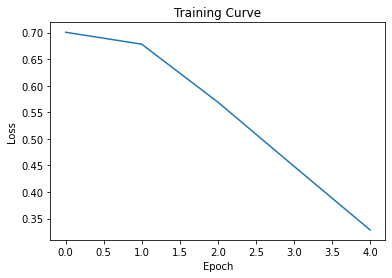

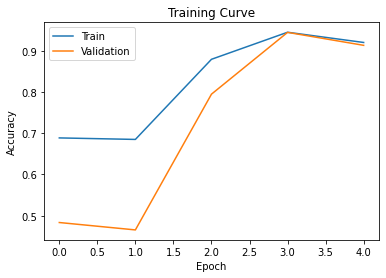

In [118]:
val_iter = torchtext.legacy.data.BucketIterator(val,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

test_iter = torchtext.legacy.data.BucketIterator(test,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

model = RNN(input_size=len(text_field.vocab.itos), hidden_size=50, num_classes=2)

train_rnn_network(model, train_iter, val_iter, learning_rate=1e-4)

### Part (c) [4 pt]

Choose at least 4 hyperparameters to tune. Explain how you tuned the hyperparameters.
You don't need to include your training curve for every model you trained.
Instead, explain what hyperparemters you tuned, what the best validation accuracy was,
and the reasoning behind the hyperparameter decisions you made.

For this assignment, you should tune more than just your learning rate and epoch. 
Choose at least 2 hyperparameters that are unrelated to the optimizer.

In [122]:
class RNN2(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(RNN2, self).__init__()
        self.emb = torch.eye(input_size)
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(2*hidden_size, num_classes)
    
    def forward(self, x):
        x = self.emb[x]
        h0 = torch.zeros(1, x.size(0), self.hidden_size)
        out, _ = self.rnn(x, h0)
        out, _ = self.rnn(x)
        out = torch.cat([torch.max(out, dim=1)[0], torch.mean(out, dim=1)], dim=1)
        out = self.fc(out)
        
        return out

Initial: | Loss 0.328538 | Train Acc 0.919927 | Val Acc 0.913004

1. Use a more effective max pool strategy: 

  Reason: want to use a max-pool strategy with the best performance
  
  Result: The Val Acc increased to 0.926457

2. Change the learning rate: 1e-4->1e-3
  
  Reason: Want to speed up the trainning

  Result: The Val Acc increased to 0.969507, which is very effective

3. Increase the number of epoch: 5->20

  Reason: The curve seems not plateaued, want to see the performance in a longer trainning period
  
  Result: The Val Acc increased to 0.95241, the curve starts to plateued after 8 epochs.
4. Change the hidden size: 50->100

  Reason: Seeing the effective of hidden size
  
  Result: The Val Acc increased to 0.960538, but shown some degree of flactuating
5. Using a better max-pool strategy.  ///Best Model///

  Increase the hidden_size: 50->100.  Increase the number of epochs: 5->20

  Reason: combine the adavantages of previous tunning, see the performance of the model

  Result: This is the best model, the Val Acc increased to 0.971300

Epoch 1 | Loss 0.719000 | Train Acc 0.517396 | Val Acc 0.125561
Epoch 2 | Loss 0.656032 | Train Acc 0.928417 | Val Acc 0.883408
Epoch 3 | Loss 0.439237 | Train Acc 0.920593 | Val Acc 0.939013
Epoch 4 | Loss 0.178438 | Train Acc 0.941735 | Val Acc 0.953363
Epoch 5 | Loss 0.215522 | Train Acc 0.956218 | Val Acc 0.940807
Epoch 6 | Loss 0.340428 | Train Acc 0.958382 | Val Acc 0.953363
Epoch 7 | Loss 0.175785 | Train Acc 0.958548 | Val Acc 0.962332
Epoch 8 | Loss 0.308764 | Train Acc 0.963043 | Val Acc 0.962332
Epoch 9 | Loss 0.133379 | Train Acc 0.963210 | Val Acc 0.955157
Epoch 10 | Loss 0.061514 | Train Acc 0.967704 | Val Acc 0.965022
Epoch 11 | Loss 0.042109 | Train Acc 0.968204 | Val Acc 0.965022
Epoch 12 | Loss 0.050682 | Train Acc 0.967205 | Val Acc 0.965022
Epoch 13 | Loss 0.019216 | Train Acc 0.969036 | Val Acc 0.956054
Epoch 14 | Loss 0.136920 | Train Acc 0.971533 | Val Acc 0.968610
Epoch 15 | Loss 0.232264 | Train Acc 0.933577 | Val Acc 0.895964
Epoch 16 | Loss 0.026547 | Train A

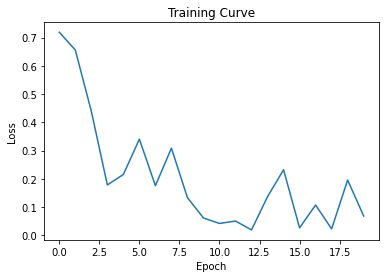

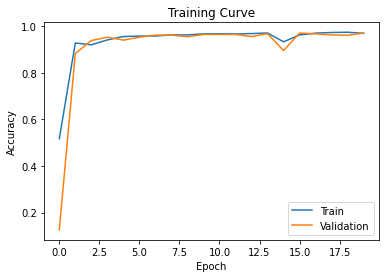

In [128]:
model2 = RNN2(input_size=len(text_field.vocab.itos), hidden_size=100, num_classes=2)

train_rnn_network(model2, train_iter, val_iter, num_epochs=20, learning_rate=1e-4)

### Part (d) [2 pt]

Before we deploy a machine learning model, we usually want to have a better understanding
of how our model performs beyond its validation accuracy. An important metric to track is
*how well our model performs in certain subsets of the data*.

In particular, what is the model's error rate amongst data with negative labels?
This is called the **false positive rate**.

What about the model's error rate amongst data with positive labels?
This is called the **false negative rate**.

Report your final model's false positive and false negative rate across the
validation set.

In [153]:
# Create a Dataset of only spam validation examples
valid_spam = torchtext.legacy.data.Dataset(
    [e for e in val.examples if e.label == 1],
    val.fields)
# Create a Dataset of only non-spam validation examples
valid_nospam = torchtext.legacy.data.Dataset(
    [e for e in val.examples if e.label == 0],
    val.fields)

valid_spam_iter = torchtext.legacy.data.BucketIterator(valid_spam,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs
valid_nospam_iter = torchtext.legacy.data.BucketIterator(valid_nospam,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

spam_acc = get_accuracy(model2, valid_spam_iter)
nospam_acc = get_accuracy(model2, valid_nospam_iter)

print("false positive rate:", (1-nospam_acc))
print("false negative rate:", (1-spam_acc))


false positive rate: 0.017435897435897463
false negative rate: 0.09999999999999998


### Part (e) [2 pt]

The impact of a false positive vs a false negative can be drastically different.
If our spam detection algorithm was deployed on your phone, what is the impact
of a false positive on the phone's user? What is the impact of a false negative?

False positive means it is not a spam but the model recognize it as a spam. 
This may cause the user failed to receive the valuable message because the algorithm has blocked it.

False negative means it is a spam but the model recognize it as a non-spam. It means the user will received the unwanted spam message and the algorithm does not successfully detect it is a spam.

## Part 4. Evaluation [11 pt]

### Part (a) [1 pt]

Report the final test accuracy of your model.

In [149]:
print(get_accuracy(model2, test_iter))

0.9730700179533214


### Part (b) [3 pt]

Report the false positive rate and false negative rate of your model across the test set.

In [154]:
# Create a Dataset of only spam test examples
test_spam = torchtext.legacy.data.Dataset(
    [e for e in val.examples if e.label == 1],
    test.fields)
# Create a Dataset of only non-spam test examples
test_nospam = torchtext.legacy.data.Dataset(
    [e for e in val.examples if e.label == 0],
    test.fields)

test_spam_iter = torchtext.legacy.data.BucketIterator(test_spam,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs
test_nospam_iter = torchtext.legacy.data.BucketIterator(test_nospam,
                                           batch_size=32,
                                           sort_key=lambda x: len(x.sms), # to minimize padding
                                           sort_within_batch=True,        # sort within each batch
                                           repeat=False)                  # repeat the iterator for many epochs

spam_acc = get_accuracy(model2, test_spam_iter)
nospam_acc = get_accuracy(model2, test_nospam_iter)

print("false positive rate:", (1-nospam_acc))
print("false negative rate:", (1-spam_acc))

false positive rate: 0.017435897435897463
false negative rate: 0.09999999999999998


### Part (c) [3 pt]

What is your model's prediction of the **probability** that
the SMS message "machine learning is sooo cool!" is spam?

Hint: To begin, use `text_field.vocab.stoi` to look up the index
of each character in the vocabulary.

In [155]:
msg = "machine learning is sooo cool!"

msg_i = []

for i in msg:
    msg_i.append(text_field.vocab.stoi[i])

msg_tensor = torch.tensor(msg_i).unsqueeze(0)
pred = model2(msg_tensor)
prob = F.softmax(pred, dim=1)
print("The probability that the SMS message 'machine learning is sooo cool!' is spam is:", float(prob[0][1]))

The probability that the SMS message 'machine learning is sooo cool!' is spam is: 0.04813644289970398


### Part (d) [4 pt]

Do you think detecting spam is an easy or difficult task?

Since machine learning models are expensive to train and deploy, it is very
important to compare our models against baseline models: a simple
model that is easy to build and inexpensive to run that we can compare our
recurrent neural network model against.

Explain how you might build a simple baseline model. This baseline model
can be a simple neural network (with very few weights), a hand-written algorithm,
or any other strategy that is easy to build and test.

**Do not actually build a baseline model. Instead, provide instructions on
how to build it.**

I think it is difficult to accurately detecting every spam message, particularlt those spams that are creating by human not auto-generated from computer. However, if you just want to blocked most of the spam that is obvious to see, it is not a very difficult task.

The simple baseline model I would like to build is simply scan through the entire message, and found the keywords in that, such as: Lucky, Surprise, Free, etc.. These words are frequently appears in a spam and if the ratio of these words in a sentence is too high, then it has a great possibility that it is a spam.

Another thing it may consider is the contact information from the sender, if the sender is a stranger or you have no previous contact with him/her, and the history of your conversation has a high rate of those target words appears, then the message received from the sender is very likely to be a spam.